In [1]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchsummary

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import random

from tqdm import tqdm

In [2]:
# settings
device = "cuda" if torch.cuda.is_available() else "cpu"

def set_seed(SEED):
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    random.seed(SEED)
    torch.cuda.manual_seed(SEED)  # type: ignore
    torch.cuda.manual_seed_all(SEED) # if use multi-GPU
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore
  
set_seed(42)

In [3]:
# hyperparameters
batch_size = 128
momentum = 0.9
weight_decay = 0.0005
lr_init = 0.01 
num_classes = 10 # CIFAR-10
n_epochs = 50

# Load Dataset
- CIFAR-10 데이터셋에 적용

In [4]:
imagenet_pca = {
    'eigval': torch.Tensor([0.2175, 0.0188, 0.0045]),
    'eigvec': torch.Tensor([
        [-0.5675,  0.7192,  0.4009],
        [-0.5808, -0.0045, -0.8140],
        [-0.5836, -0.6948,  0.4203],
    ])
}

# Lighting data augmentation take from here 
# - https://github.com/eladhoffer/convNet.pytorch/blob/master/preprocess.py
class Lighting(object):
    """Lighting noise(AlexNet - style PCA - based noise)"""

    def __init__(self, alphastd, eigval, eigvec):
        self.alphastd = alphastd
        self.eigval = eigval
        self.eigvec = eigvec

    def __call__(self, img):
        if self.alphastd == 0:
            return img

        alpha = img.new().resize_(3).normal_(0, self.alphastd)
        rgb = self.eigvec.type_as(img).clone()\
            .mul(alpha.view(1, 3).expand(3, 3))\
            .mul(self.eigval.view(1, 3).expand(3, 3))\
            .sum(1).squeeze()
        return img.add(rgb.view(3, 1, 1).expand_as(img))

In [5]:
transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Resize(227, antialias=True),
            transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)), # 논문에서는 학습 데이터 이미지의 평균과 표준편차를 사용하지만, 여기서는 둘 다 0.5로 설정
            Lighting(0.1, imagenet_pca["eigval"], imagenet_pca["eigvec"])
            ])

train = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)

test = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
test_dataloader = DataLoader(test, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


# Modeling

In [6]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super().__init__()

        # cnn layers
        self.net= nn.Sequential(
            # conv1
            nn.Conv2d(3, 96, kernel_size=11, stride=4),
            nn.ReLU(inplace=True), # non-saturating function
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2), # 논문의 LRN 파라미터
            nn.MaxPool2d(kernel_size=3, stride=2),
 
            # conv2
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),

            # conv3
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # conv4
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # conv5
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
          )
        
        # fc layers
        self.fc = nn.Sequential(
            nn.Dropout(p = 0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )
      
    def init_bias(self):
        for layer in self.net:
            if isinstance(layer, nn.Conv2d): # Conv2d 레이어의 경우
                nn.init.normal_(layer.weight, mean=0, std=0.01)
                nn.init.constant_(layer.bias, 0)
            elif isinstance(layer, nn.Linear): # fc 레이어의 경우
                nn.init.normal_(layer.weight, mean=0, std=0.01)
        layer_num = [4, 10, 12, 16, 19] # bias를 1로 초기화할 레이어(conv2, conv4, conv5, hidden fc layers)
        for n in layer:
            nn.init.constant_(self.net[n].bias, 1)
      
    def forward(self, x):
        output = self.net(x)
        output = output.view(-1, 256 * 6 * 6)
        output = self.fc(output)

        return output
          

input size는 227x227 <br> [참고링크](https://discuss.pytorch.org/t/alexnet-input-size-224-or-227/41272/3)

In [7]:
torchsummary.summary(AlexNet(num_classes=num_classes).to(device), (3, 227, 227), 128) # (model, input_shape, batch_Size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [128, 96, 55, 55]          34,944
              ReLU-2          [128, 96, 55, 55]               0
 LocalResponseNorm-3          [128, 96, 55, 55]               0
         MaxPool2d-4          [128, 96, 27, 27]               0
            Conv2d-5         [128, 256, 27, 27]         614,656
              ReLU-6         [128, 256, 27, 27]               0
 LocalResponseNorm-7         [128, 256, 27, 27]               0
         MaxPool2d-8         [128, 256, 13, 13]               0
            Conv2d-9         [128, 384, 13, 13]         885,120
             ReLU-10         [128, 384, 13, 13]               0
           Conv2d-11         [128, 384, 13, 13]       1,327,488
             ReLU-12         [128, 384, 13, 13]               0
           Conv2d-13         [128, 256, 13, 13]         884,992
             ReLU-14         [128, 256,

# Train

In [16]:
def train(model, device, train_dataloader, optimizer, scheduler, crietrion, epoch):
    train_loss = 0
    model.train()
    print(f"Epoch: {epoch}/{n_epochs}")
    for i, (data, target) in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()
        
        data, target = data.to(device), target.to(device)

        pred = model(data)
        loss = criterion(pred, target)

        train_loss += loss.item()

        loss.backward()
        optimizer.step()
    
    avg_train_loss = train_loss / len(train_dataloader)
    print(f"Train Loss: {avg_train_loss:.6f}")
    
    return avg_train_loss

In [10]:
def test(model, device, test_dataloader, criterion):

    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in tqdm(test_dataloader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()

            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
        
        avg_test_loss = test_loss / len(test_dataloader)

        avg_acc = correct/len(test_dataloader.dataset)

        print(f"Test Loss: {avg_test_loss:.6f}\t Accuracy: {correct}/{len(test_dataloader.dataset)} ({100 * avg_acc:.2f}%)")
        print("-" * 50)
    return avg_test_loss, avg_acc

In [17]:
criterion = nn.CrossEntropyLoss()
model = AlexNet(num_classes=num_classes).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr_init, momentum=momentum, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode="min", \
                                                    factor=0.1, patience=1, min_lr=0.00001)

In [18]:
train_loss_list = []
test_loss_list = []
test_acc_list = []

for epoch in range(1, n_epochs+1):
    train_loss = train(model, device, train_dataloader, optimizer, scheduler, criterion, epoch)
    val_loss, val_acc = test(model, device, test_dataloader, criterion)
    scheduler.step(val_loss)
    train_loss_list.append(train_loss)
    test_loss_list.append(val_loss)
    test_acc_list.append(val_acc)

Epoch: 1/50


100%|██████████| 391/391 [01:57<00:00,  3.33it/s]


Train Loss: 2.302685


100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


Test Loss: 2.301315	 Accuracy: 1000/10000 (10.00%)
--------------------------------------------------
Epoch: 2/50


100%|██████████| 391/391 [02:00<00:00,  3.26it/s]


Train Loss: 2.124562


100%|██████████| 79/79 [00:24<00:00,  3.26it/s]


Test Loss: 1.758097	 Accuracy: 3520/10000 (35.20%)
--------------------------------------------------
Epoch: 3/50


100%|██████████| 391/391 [01:57<00:00,  3.32it/s]


Train Loss: 1.615503


100%|██████████| 79/79 [00:26<00:00,  3.00it/s]


Test Loss: 1.417037	 Accuracy: 4656/10000 (46.56%)
--------------------------------------------------
Epoch: 4/50


100%|██████████| 391/391 [02:07<00:00,  3.07it/s]


Train Loss: 1.380551


100%|██████████| 79/79 [00:26<00:00,  3.02it/s]


Test Loss: 1.238772	 Accuracy: 5518/10000 (55.18%)
--------------------------------------------------
Epoch: 5/50


100%|██████████| 391/391 [02:05<00:00,  3.11it/s]


Train Loss: 1.192083


100%|██████████| 79/79 [00:27<00:00,  2.92it/s]


Test Loss: 1.063023	 Accuracy: 6169/10000 (61.69%)
--------------------------------------------------
Epoch: 6/50


100%|██████████| 391/391 [02:06<00:00,  3.09it/s]


Train Loss: 0.998684


100%|██████████| 79/79 [00:26<00:00,  2.99it/s]


Test Loss: 0.956656	 Accuracy: 6608/10000 (66.08%)
--------------------------------------------------
Epoch: 7/50


100%|██████████| 391/391 [02:06<00:00,  3.09it/s]


Train Loss: 0.875207


100%|██████████| 79/79 [00:26<00:00,  2.94it/s]


Test Loss: 0.809231	 Accuracy: 7184/10000 (71.84%)
--------------------------------------------------
Epoch: 8/50


100%|██████████| 391/391 [02:05<00:00,  3.12it/s]


Train Loss: 0.773484


100%|██████████| 79/79 [00:26<00:00,  3.02it/s]


Test Loss: 0.728389	 Accuracy: 7487/10000 (74.87%)
--------------------------------------------------
Epoch: 9/50


100%|██████████| 391/391 [02:05<00:00,  3.13it/s]


Train Loss: 0.704888


100%|██████████| 79/79 [00:26<00:00,  2.97it/s]


Test Loss: 0.721509	 Accuracy: 7573/10000 (75.73%)
--------------------------------------------------
Epoch: 10/50


100%|██████████| 391/391 [02:04<00:00,  3.13it/s]


Train Loss: 0.646638


100%|██████████| 79/79 [00:25<00:00,  3.08it/s]


Test Loss: 0.627011	 Accuracy: 7851/10000 (78.51%)
--------------------------------------------------
Epoch: 11/50


100%|██████████| 391/391 [02:05<00:00,  3.12it/s]


Train Loss: 0.593971


100%|██████████| 79/79 [00:25<00:00,  3.06it/s]


Test Loss: 0.626680	 Accuracy: 7845/10000 (78.45%)
--------------------------------------------------
Epoch: 12/50


100%|██████████| 391/391 [02:04<00:00,  3.14it/s]


Train Loss: 0.542046


100%|██████████| 79/79 [00:25<00:00,  3.05it/s]


Test Loss: 0.560457	 Accuracy: 8081/10000 (80.81%)
--------------------------------------------------
Epoch: 13/50


100%|██████████| 391/391 [02:05<00:00,  3.13it/s]


Train Loss: 0.505576


100%|██████████| 79/79 [00:26<00:00,  3.01it/s]


Test Loss: 0.530934	 Accuracy: 8199/10000 (81.99%)
--------------------------------------------------
Epoch: 14/50


100%|██████████| 391/391 [02:06<00:00,  3.08it/s]


Train Loss: 0.470611


100%|██████████| 79/79 [00:26<00:00,  3.03it/s]


Test Loss: 0.552445	 Accuracy: 8129/10000 (81.29%)
--------------------------------------------------
Epoch: 15/50


100%|██████████| 391/391 [02:06<00:00,  3.10it/s]


Train Loss: 0.441690


100%|██████████| 79/79 [00:26<00:00,  3.00it/s]


Test Loss: 0.499864	 Accuracy: 8283/10000 (82.83%)
--------------------------------------------------
Epoch: 16/50


100%|██████████| 391/391 [02:05<00:00,  3.12it/s]


Train Loss: 0.409308


100%|██████████| 79/79 [00:26<00:00,  3.03it/s]


Test Loss: 0.483641	 Accuracy: 8335/10000 (83.35%)
--------------------------------------------------
Epoch: 17/50


100%|██████████| 391/391 [02:05<00:00,  3.12it/s]


Train Loss: 0.387108


100%|██████████| 79/79 [00:26<00:00,  3.00it/s]


Test Loss: 0.473813	 Accuracy: 8415/10000 (84.15%)
--------------------------------------------------
Epoch: 18/50


100%|██████████| 391/391 [02:04<00:00,  3.14it/s]


Train Loss: 0.363582


100%|██████████| 79/79 [00:25<00:00,  3.06it/s]


Test Loss: 0.469920	 Accuracy: 8415/10000 (84.15%)
--------------------------------------------------
Epoch: 19/50


100%|██████████| 391/391 [02:05<00:00,  3.12it/s]


Train Loss: 0.334133


100%|██████████| 79/79 [00:26<00:00,  3.03it/s]


Test Loss: 0.475986	 Accuracy: 8423/10000 (84.23%)
--------------------------------------------------
Epoch: 20/50


100%|██████████| 391/391 [02:06<00:00,  3.10it/s]


Train Loss: 0.319572


100%|██████████| 79/79 [00:26<00:00,  2.96it/s]


Test Loss: 0.431312	 Accuracy: 8552/10000 (85.52%)
--------------------------------------------------
Epoch: 21/50


100%|██████████| 391/391 [02:04<00:00,  3.13it/s]


Train Loss: 0.298995


100%|██████████| 79/79 [00:25<00:00,  3.06it/s]


Test Loss: 0.415830	 Accuracy: 8578/10000 (85.78%)
--------------------------------------------------
Epoch: 22/50


100%|██████████| 391/391 [02:05<00:00,  3.13it/s]


Train Loss: 0.283823


100%|██████████| 79/79 [00:26<00:00,  3.02it/s]


Test Loss: 0.440780	 Accuracy: 8549/10000 (85.49%)
--------------------------------------------------
Epoch: 23/50


100%|██████████| 391/391 [02:04<00:00,  3.14it/s]


Train Loss: 0.263124


100%|██████████| 79/79 [00:25<00:00,  3.04it/s]


Test Loss: 0.420172	 Accuracy: 8639/10000 (86.39%)
--------------------------------------------------
Epoch: 24/50


100%|██████████| 391/391 [02:05<00:00,  3.12it/s]


Train Loss: 0.174966


100%|██████████| 79/79 [00:25<00:00,  3.05it/s]


Test Loss: 0.380860	 Accuracy: 8778/10000 (87.78%)
--------------------------------------------------
Epoch: 25/50


100%|██████████| 391/391 [02:05<00:00,  3.13it/s]


Train Loss: 0.150952


100%|██████████| 79/79 [00:26<00:00,  2.96it/s]


Test Loss: 0.375455	 Accuracy: 8796/10000 (87.96%)
--------------------------------------------------
Epoch: 26/50


100%|██████████| 391/391 [02:06<00:00,  3.08it/s]


Train Loss: 0.141802


100%|██████████| 79/79 [00:25<00:00,  3.05it/s]


Test Loss: 0.384206	 Accuracy: 8806/10000 (88.06%)
--------------------------------------------------
Epoch: 27/50


100%|██████████| 391/391 [02:06<00:00,  3.09it/s]


Train Loss: 0.135969


100%|██████████| 79/79 [00:26<00:00,  3.01it/s]


Test Loss: 0.382475	 Accuracy: 8795/10000 (87.95%)
--------------------------------------------------
Epoch: 28/50


100%|██████████| 391/391 [02:06<00:00,  3.10it/s]


Train Loss: 0.125046


100%|██████████| 79/79 [00:26<00:00,  3.02it/s]


Test Loss: 0.377171	 Accuracy: 8800/10000 (88.00%)
--------------------------------------------------
Epoch: 29/50


100%|██████████| 391/391 [02:06<00:00,  3.10it/s]


Train Loss: 0.125751


100%|██████████| 79/79 [00:26<00:00,  3.00it/s]


Test Loss: 0.376064	 Accuracy: 8805/10000 (88.05%)
--------------------------------------------------
Epoch: 30/50


100%|██████████| 391/391 [02:06<00:00,  3.08it/s]


Train Loss: 0.122565


100%|██████████| 79/79 [00:26<00:00,  3.02it/s]


Test Loss: 0.378009	 Accuracy: 8825/10000 (88.25%)
--------------------------------------------------
Epoch: 31/50


100%|██████████| 391/391 [02:05<00:00,  3.11it/s]


Train Loss: 0.123430


100%|██████████| 79/79 [00:26<00:00,  2.93it/s]


Test Loss: 0.381277	 Accuracy: 8819/10000 (88.19%)
--------------------------------------------------
Epoch: 32/50


100%|██████████| 391/391 [02:06<00:00,  3.08it/s]


Train Loss: 0.123640


100%|██████████| 79/79 [00:26<00:00,  2.96it/s]


Test Loss: 0.380088	 Accuracy: 8810/10000 (88.10%)
--------------------------------------------------
Epoch: 33/50


100%|██████████| 391/391 [02:07<00:00,  3.07it/s]


Train Loss: 0.122629


100%|██████████| 79/79 [00:26<00:00,  3.02it/s]


Test Loss: 0.378808	 Accuracy: 8832/10000 (88.32%)
--------------------------------------------------
Epoch: 34/50


100%|██████████| 391/391 [02:06<00:00,  3.08it/s]


Train Loss: 0.121320


100%|██████████| 79/79 [00:26<00:00,  2.99it/s]


Test Loss: 0.378928	 Accuracy: 8823/10000 (88.23%)
--------------------------------------------------
Epoch: 35/50


100%|██████████| 391/391 [02:08<00:00,  3.04it/s]


Train Loss: 0.120070


100%|██████████| 79/79 [00:26<00:00,  3.00it/s]


Test Loss: 0.380814	 Accuracy: 8803/10000 (88.03%)
--------------------------------------------------
Epoch: 36/50


100%|██████████| 391/391 [02:07<00:00,  3.08it/s]


Train Loss: 0.120271


100%|██████████| 79/79 [00:26<00:00,  3.00it/s]


Test Loss: 0.381894	 Accuracy: 8815/10000 (88.15%)
--------------------------------------------------
Epoch: 37/50


100%|██████████| 391/391 [02:07<00:00,  3.06it/s]


Train Loss: 0.121392


100%|██████████| 79/79 [00:26<00:00,  2.96it/s]


Test Loss: 0.379060	 Accuracy: 8833/10000 (88.33%)
--------------------------------------------------
Epoch: 38/50


100%|██████████| 391/391 [02:07<00:00,  3.07it/s]


Train Loss: 0.123113


100%|██████████| 79/79 [00:26<00:00,  3.00it/s]


Test Loss: 0.377903	 Accuracy: 8836/10000 (88.36%)
--------------------------------------------------
Epoch: 39/50


100%|██████████| 391/391 [02:06<00:00,  3.09it/s]


Train Loss: 0.123638


100%|██████████| 79/79 [00:26<00:00,  3.03it/s]


Test Loss: 0.380092	 Accuracy: 8816/10000 (88.16%)
--------------------------------------------------
Epoch: 40/50


100%|██████████| 391/391 [02:06<00:00,  3.10it/s]


Train Loss: 0.122292


100%|██████████| 79/79 [00:26<00:00,  2.95it/s]


Test Loss: 0.373991	 Accuracy: 8832/10000 (88.32%)
--------------------------------------------------
Epoch: 41/50


100%|██████████| 391/391 [02:05<00:00,  3.13it/s]


Train Loss: 0.119802


100%|██████████| 79/79 [00:26<00:00,  3.01it/s]


Test Loss: 0.383089	 Accuracy: 8818/10000 (88.18%)
--------------------------------------------------
Epoch: 42/50


100%|██████████| 391/391 [02:04<00:00,  3.13it/s]


Train Loss: 0.122947


100%|██████████| 79/79 [00:25<00:00,  3.06it/s]


Test Loss: 0.380345	 Accuracy: 8838/10000 (88.38%)
--------------------------------------------------
Epoch: 43/50


100%|██████████| 391/391 [02:06<00:00,  3.09it/s]


Train Loss: 0.122721


100%|██████████| 79/79 [00:25<00:00,  3.04it/s]


Test Loss: 0.375490	 Accuracy: 8821/10000 (88.21%)
--------------------------------------------------
Epoch: 44/50


100%|██████████| 391/391 [02:04<00:00,  3.15it/s]


Train Loss: 0.119879


100%|██████████| 79/79 [00:25<00:00,  3.09it/s]


Test Loss: 0.377063	 Accuracy: 8814/10000 (88.14%)
--------------------------------------------------
Epoch: 45/50


100%|██████████| 391/391 [02:04<00:00,  3.14it/s]


Train Loss: 0.121911


100%|██████████| 79/79 [00:25<00:00,  3.05it/s]


Test Loss: 0.379080	 Accuracy: 8826/10000 (88.26%)
--------------------------------------------------
Epoch: 46/50


100%|██████████| 391/391 [02:05<00:00,  3.12it/s]


Train Loss: 0.120693


100%|██████████| 79/79 [00:26<00:00,  3.03it/s]


Test Loss: 0.383288	 Accuracy: 8828/10000 (88.28%)
--------------------------------------------------
Epoch: 47/50


100%|██████████| 391/391 [02:05<00:00,  3.11it/s]


Train Loss: 0.120550


100%|██████████| 79/79 [00:26<00:00,  3.02it/s]


Test Loss: 0.378331	 Accuracy: 8838/10000 (88.38%)
--------------------------------------------------
Epoch: 48/50


100%|██████████| 391/391 [02:07<00:00,  3.08it/s]


Train Loss: 0.121496


100%|██████████| 79/79 [00:26<00:00,  3.01it/s]


Test Loss: 0.379780	 Accuracy: 8826/10000 (88.26%)
--------------------------------------------------
Epoch: 49/50


100%|██████████| 391/391 [02:07<00:00,  3.07it/s]


Train Loss: 0.121812


100%|██████████| 79/79 [00:26<00:00,  3.00it/s]


Test Loss: 0.374728	 Accuracy: 8825/10000 (88.25%)
--------------------------------------------------
Epoch: 50/50


100%|██████████| 391/391 [02:05<00:00,  3.11it/s]


Train Loss: 0.119136


100%|██████████| 79/79 [00:26<00:00,  2.97it/s]

Test Loss: 0.377083	 Accuracy: 8839/10000 (88.39%)
--------------------------------------------------


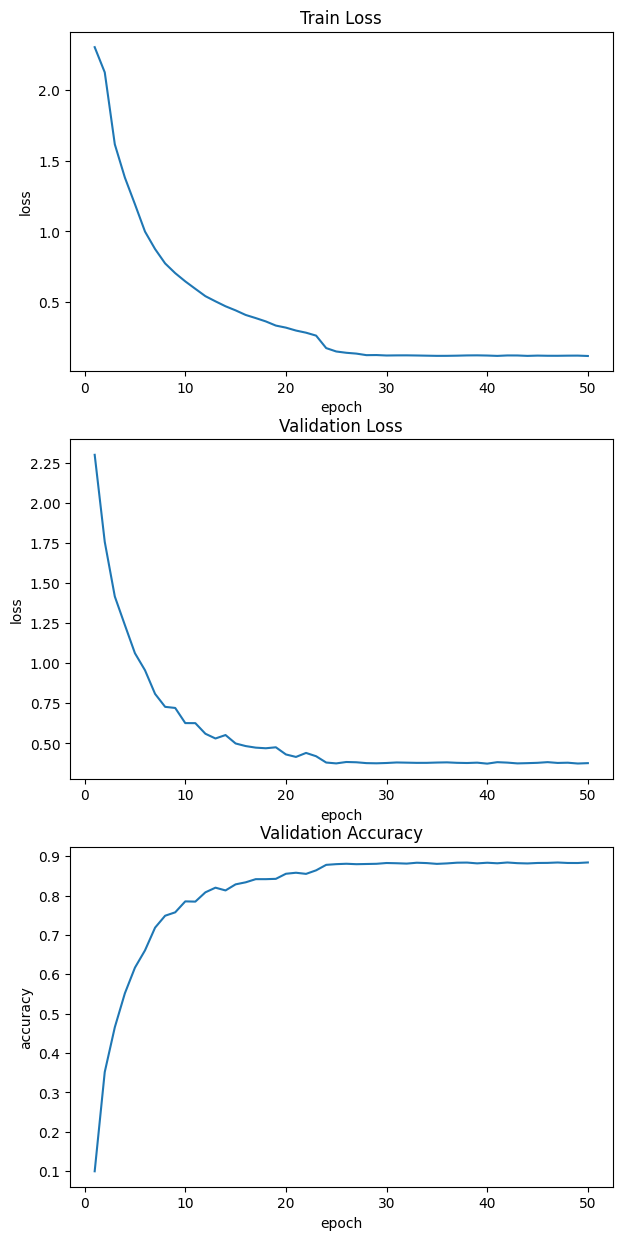

In [30]:
# plot
plt.figure(figsize=(7, 15))
plt.subplot(3, 1, 1)
plt.plot(range(1, n_epochs+1), train_loss_list)
plt.title("Train Loss")
plt.xlabel("epoch")
plt.ylabel("loss")

plt.subplot(3, 1, 2)
plt.plot(range(1, n_epochs+1), test_loss_list)
plt.title("Validation Loss")
plt.xlabel("epoch")
plt.ylabel("loss")

plt.subplot(3, 1, 3)
plt.plot(range(1, n_epochs+1), test_acc_list)
plt.title("Validation Accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")

plt.show()

cat


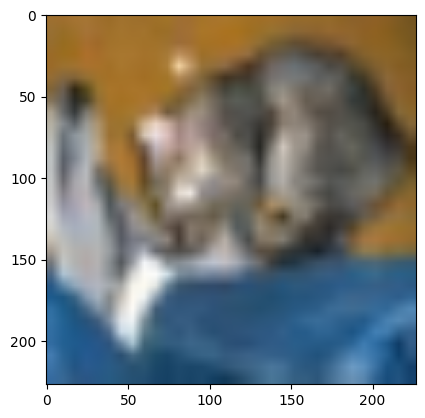

In [31]:
# 결과 확인
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0))) # pytorch z, x, y -> numpy, matplotlib x, y, z 형태 변환(index)
    
# get some random training images
dataiter = iter(test_dataloader) # iter(호출가능한객체, 반복을끝낼값)
images, labels = next(dataiter) # next() : 반복할 수 있을 때는 해당 값을 출력하고, 반복이 끝났을 때는 기본값을 출력

class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# create grid of images
img_grid = torchvision.utils.make_grid(images[0]) # make_grid : 이미지의 그리드 생성
# show images & labels
matplotlib_imshow(img_grid)
print(class_names[labels[0]])

GroundTruth:  cat   ship  ship  plane
Predicted:  cat   ship  ship  plane


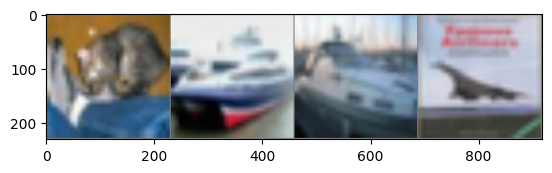

In [33]:
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

outputs=model(images.to(device))
_, predicted = torch.max(outputs, 1)

# 이미지 출력
matplotlib_imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join(f'{class_names[labels[j]]:5s}' for j in range(4)))
print('Predicted: ', ' '.join(f'{class_names[predicted[j]]:5s}'
                              for j in range(4)))

In [35]:
# 클래스별 예측 정확도

# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in class_names}
total_pred = {classname: 0 for classname in class_names}

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = model(images.to(device))
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수 모으기
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[class_names[label]] += 1
            total_pred[class_names[label]] += 1


# 각 분류별 정확도(accuracy)를 출력
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 90.5 %
Accuracy for class: car   is 94.0 %
Accuracy for class: bird  is 83.5 %
Accuracy for class: cat   is 77.7 %
Accuracy for class: deer  is 88.3 %
Accuracy for class: dog   is 80.7 %
Accuracy for class: frog  is 92.4 %
Accuracy for class: horse is 90.9 %
Accuracy for class: ship  is 93.8 %
Accuracy for class: truck is 91.7 %
